# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

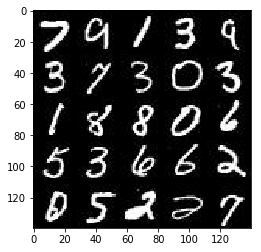

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

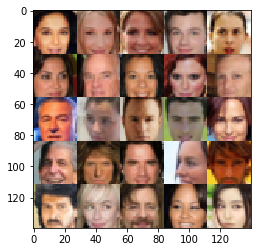

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha): 
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    customer_kernel_initializer = tf.random_normal_initializer(mean = 0, stddev = 0.02)
    with tf.variable_scope('discriminator', reuse=reuse): 
        
        # Input layer : images size = 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = customer_kernel_initializer)
        relu1 = leaky_relu(x1, alpha=alpha) # leaky ReLU
        # now 14*14*64
                
        # Conv layer with batch norm:
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer = customer_kernel_initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha=alpha)
        # now 7*7*128

        # Conv layer with batch norm
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer = customer_kernel_initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha=alpha)
        # now 4*4*256
        
        # Conv layer with batch norm
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # Reshape inputs from flat
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha=alpha)
        # now 4*4*256
        
        # Conv2d with transpose, batch norm, leaky ReLU
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha=alpha)
        # 7*7*128

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha=alpha)
        # 14*14*64

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim, alpha=alpha)
    d_output_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*(1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # all training variables
    t_vars = tf.trainable_variables()
    # discriminator variables
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    # generator variables
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    # TODO: Build Model
    all_samples, losses = [], []
    steps = 0
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[-1]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels, alpha=0.2)                
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Train
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                
                # Print training progress
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_real:batch_images, inputs_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_count+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                # Sample generator's output
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(inputs_z, image_channels, is_train=False), feed_dict={inputs_z: batch_z})
                    all_samples.append(gen_samples)
                    show_generator_output(sess, 25, inputs_z, out_channel_dim=image_channels, image_mode=data_image_mode)
                
#         saver.save(sess, './checkpoints/generator.ckpt')
    
    with open('./samples.pkl', 'wb') as f:
        pkl.dump(all_samples, f)
    with open('./losses.pkl', 'wb') as g: 
        pkl.dump(losses, g)

    return losses, all_samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 4/3... Discriminator Loss: 0.5706... Generator Loss: 5.6231
Epoch 4/3... Discriminator Loss: 0.4270... Generator Loss: 3.1446
Epoch 4/3... Discriminator Loss: 1.3863... Generator Loss: 17.4752
Epoch 4/3... Discriminator Loss: 2.4089... Generator Loss: 0.2275
Epoch 4/3... Discriminator Loss: 0.5138... Generator Loss: 4.0252
Epoch 4/3... Discriminator Loss: 0.6141... Generator Loss: 2.0759
Epoch 4/3... Discriminator Loss: 0.4944... Generator Loss: 2.5691
Epoch 4/3... Discriminator Loss: 0.5617... Generator Loss: 2.9665
Epoch 4/3... Discriminator Loss: 1.0775... Generator Loss: 3.1426
Epoch 4/3... Discriminator Loss: 1.3397... Generator Loss: 0.9863


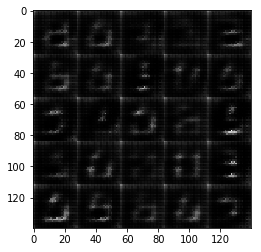

Epoch 4/3... Discriminator Loss: 1.6921... Generator Loss: 0.4749
Epoch 4/3... Discriminator Loss: 1.3228... Generator Loss: 0.6673
Epoch 4/3... Discriminator Loss: 0.6264... Generator Loss: 3.6198
Epoch 4/3... Discriminator Loss: 0.8169... Generator Loss: 3.8091
Epoch 4/3... Discriminator Loss: 0.8034... Generator Loss: 1.5081
Epoch 4/3... Discriminator Loss: 0.9812... Generator Loss: 2.2288
Epoch 4/3... Discriminator Loss: 0.8697... Generator Loss: 1.5085
Epoch 4/3... Discriminator Loss: 0.9384... Generator Loss: 1.0922
Epoch 4/3... Discriminator Loss: 0.7882... Generator Loss: 1.4335
Epoch 4/3... Discriminator Loss: 1.3363... Generator Loss: 2.5978


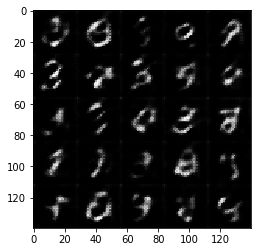

Epoch 4/3... Discriminator Loss: 0.8389... Generator Loss: 1.4223
Epoch 4/3... Discriminator Loss: 1.0924... Generator Loss: 1.2943
Epoch 4/3... Discriminator Loss: 1.2514... Generator Loss: 2.6358
Epoch 4/3... Discriminator Loss: 1.3016... Generator Loss: 2.9302
Epoch 4/3... Discriminator Loss: 1.1264... Generator Loss: 2.3053
Epoch 4/3... Discriminator Loss: 1.0170... Generator Loss: 1.4688
Epoch 4/3... Discriminator Loss: 0.8804... Generator Loss: 1.6179
Epoch 4/3... Discriminator Loss: 1.0087... Generator Loss: 1.3959
Epoch 4/3... Discriminator Loss: 0.8779... Generator Loss: 1.4429
Epoch 4/3... Discriminator Loss: 1.0988... Generator Loss: 0.8039


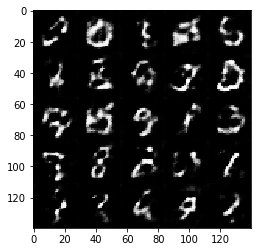

Epoch 4/3... Discriminator Loss: 0.9783... Generator Loss: 1.1318
Epoch 4/3... Discriminator Loss: 1.0462... Generator Loss: 1.9401
Epoch 4/3... Discriminator Loss: 0.9731... Generator Loss: 1.8270


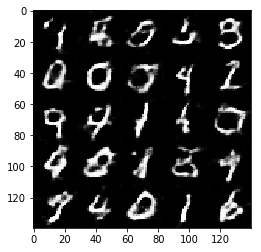

Epoch 4/3... Discriminator Loss: 1.5290... Generator Loss: 2.8318
Epoch 4/3... Discriminator Loss: 0.9867... Generator Loss: 1.4710
Epoch 4/3... Discriminator Loss: 0.9248... Generator Loss: 1.4447
Epoch 4/3... Discriminator Loss: 0.9635... Generator Loss: 1.1702
Epoch 4/3... Discriminator Loss: 1.5145... Generator Loss: 2.8644
Epoch 4/3... Discriminator Loss: 0.9617... Generator Loss: 1.1144
Epoch 4/3... Discriminator Loss: 1.2554... Generator Loss: 2.2720
Epoch 4/3... Discriminator Loss: 1.0724... Generator Loss: 1.9248
Epoch 4/3... Discriminator Loss: 1.0818... Generator Loss: 0.9382
Epoch 4/3... Discriminator Loss: 1.0738... Generator Loss: 1.6991


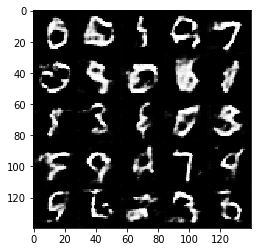

Epoch 4/3... Discriminator Loss: 1.4354... Generator Loss: 0.5264
Epoch 4/3... Discriminator Loss: 1.0103... Generator Loss: 1.9278
Epoch 4/3... Discriminator Loss: 1.0046... Generator Loss: 1.4248
Epoch 4/3... Discriminator Loss: 1.1571... Generator Loss: 0.7529
Epoch 4/3... Discriminator Loss: 1.0826... Generator Loss: 0.9132
Epoch 4/3... Discriminator Loss: 1.0541... Generator Loss: 0.9001
Epoch 4/3... Discriminator Loss: 1.2423... Generator Loss: 1.0327
Epoch 4/3... Discriminator Loss: 0.9600... Generator Loss: 1.2537
Epoch 4/3... Discriminator Loss: 0.9966... Generator Loss: 1.4546
Epoch 4/3... Discriminator Loss: 1.1053... Generator Loss: 0.9216


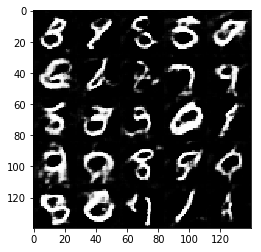

Epoch 4/3... Discriminator Loss: 1.0168... Generator Loss: 1.1996
Epoch 4/3... Discriminator Loss: 1.0387... Generator Loss: 1.6360
Epoch 4/3... Discriminator Loss: 1.3065... Generator Loss: 2.4243
Epoch 4/3... Discriminator Loss: 0.9919... Generator Loss: 1.0862
Epoch 4/3... Discriminator Loss: 1.4573... Generator Loss: 0.4639
Epoch 4/3... Discriminator Loss: 1.3139... Generator Loss: 2.0877
Epoch 4/3... Discriminator Loss: 0.8854... Generator Loss: 1.3651
Epoch 4/3... Discriminator Loss: 1.1006... Generator Loss: 1.8813
Epoch 4/3... Discriminator Loss: 1.1825... Generator Loss: 0.6779
Epoch 4/3... Discriminator Loss: 0.9193... Generator Loss: 1.4268


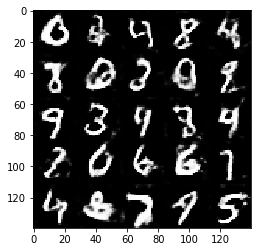

In [ ]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
batch = mnist_dataset.get_batches(batch_size)

with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

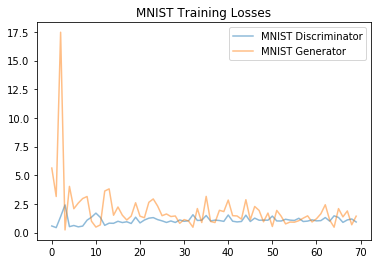

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='MNIST Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='MNIST Generator', alpha=0.5)
plt.title("MNIST Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 2/1... Discriminator Loss: 5.2958... Generator Loss: 0.0126
Epoch 2/1... Discriminator Loss: 0.6749... Generator Loss: 15.3869
Epoch 2/1... Discriminator Loss: 0.5626... Generator Loss: 3.5580
Epoch 2/1... Discriminator Loss: 2.1592... Generator Loss: 0.2402
Epoch 2/1... Discriminator Loss: 0.7912... Generator Loss: 4.0108
Epoch 2/1... Discriminator Loss: 2.0785... Generator Loss: 0.2689
Epoch 2/1... Discriminator Loss: 0.9025... Generator Loss: 1.2060
Epoch 2/1... Discriminator Loss: 0.7223... Generator Loss: 2.0651
Epoch 2/1... Discriminator Loss: 1.0027... Generator Loss: 0.9001
Epoch 2/1... Discriminator Loss: 0.7639... Generator Loss: 1.2799


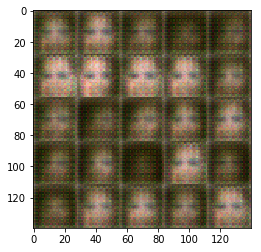

Epoch 2/1... Discriminator Loss: 0.7810... Generator Loss: 2.4823
Epoch 2/1... Discriminator Loss: 0.6352... Generator Loss: 2.6077
Epoch 2/1... Discriminator Loss: 0.6011... Generator Loss: 3.1546
Epoch 2/1... Discriminator Loss: 0.6210... Generator Loss: 2.5880
Epoch 2/1... Discriminator Loss: 0.7818... Generator Loss: 1.5866
Epoch 2/1... Discriminator Loss: 0.8954... Generator Loss: 1.7258
Epoch 2/1... Discriminator Loss: 0.8782... Generator Loss: 4.0011
Epoch 2/1... Discriminator Loss: 1.0477... Generator Loss: 2.3454
Epoch 2/1... Discriminator Loss: 0.7509... Generator Loss: 1.5451
Epoch 2/1... Discriminator Loss: 1.2625... Generator Loss: 0.9941


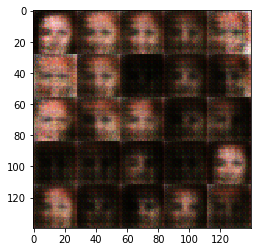

Epoch 2/1... Discriminator Loss: 1.1039... Generator Loss: 1.4295
Epoch 2/1... Discriminator Loss: 1.1063... Generator Loss: 0.9547
Epoch 2/1... Discriminator Loss: 0.8074... Generator Loss: 1.8960
Epoch 2/1... Discriminator Loss: 0.9772... Generator Loss: 0.9188
Epoch 2/1... Discriminator Loss: 1.0734... Generator Loss: 1.4115
Epoch 2/1... Discriminator Loss: 0.7609... Generator Loss: 1.7290
Epoch 2/1... Discriminator Loss: 0.9737... Generator Loss: 1.1344
Epoch 2/1... Discriminator Loss: 0.9032... Generator Loss: 1.0947
Epoch 2/1... Discriminator Loss: 0.7808... Generator Loss: 1.8572
Epoch 2/1... Discriminator Loss: 1.1199... Generator Loss: 0.8137


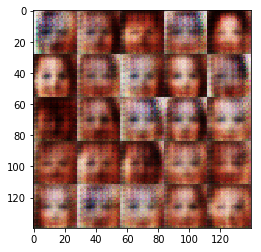

Epoch 2/1... Discriminator Loss: 1.1551... Generator Loss: 0.8426
Epoch 2/1... Discriminator Loss: 0.9098... Generator Loss: 1.5730
Epoch 2/1... Discriminator Loss: 0.9513... Generator Loss: 1.1924
Epoch 2/1... Discriminator Loss: 1.2522... Generator Loss: 0.7318
Epoch 2/1... Discriminator Loss: 0.7669... Generator Loss: 1.4890
Epoch 2/1... Discriminator Loss: 1.0044... Generator Loss: 1.0107
Epoch 2/1... Discriminator Loss: 0.9421... Generator Loss: 1.2978
Epoch 2/1... Discriminator Loss: 1.1882... Generator Loss: 2.9612
Epoch 2/1... Discriminator Loss: 0.7353... Generator Loss: 1.8151
Epoch 2/1... Discriminator Loss: 1.6240... Generator Loss: 0.5233


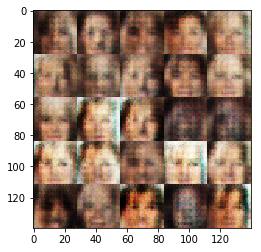

Epoch 2/1... Discriminator Loss: 1.1198... Generator Loss: 0.8014
Epoch 2/1... Discriminator Loss: 0.9926... Generator Loss: 1.2499
Epoch 2/1... Discriminator Loss: 1.3083... Generator Loss: 1.1593
Epoch 2/1... Discriminator Loss: 1.3454... Generator Loss: 3.0993
Epoch 2/1... Discriminator Loss: 1.1064... Generator Loss: 3.2142
Epoch 2/1... Discriminator Loss: 1.3177... Generator Loss: 0.6314
Epoch 2/1... Discriminator Loss: 1.0849... Generator Loss: 0.9841
Epoch 2/1... Discriminator Loss: 1.1835... Generator Loss: 0.6988
Epoch 2/1... Discriminator Loss: 1.0285... Generator Loss: 1.1298
Epoch 2/1... Discriminator Loss: 1.0337... Generator Loss: 1.0192


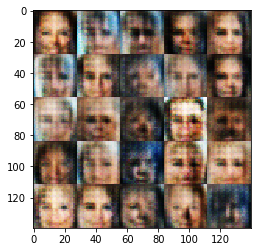

Epoch 2/1... Discriminator Loss: 0.9596... Generator Loss: 1.5748
Epoch 2/1... Discriminator Loss: 1.0444... Generator Loss: 0.9679
Epoch 2/1... Discriminator Loss: 0.9075... Generator Loss: 1.2515
Epoch 2/1... Discriminator Loss: 1.0024... Generator Loss: 1.4647
Epoch 2/1... Discriminator Loss: 1.7992... Generator Loss: 0.3373
Epoch 2/1... Discriminator Loss: 1.0005... Generator Loss: 1.3608
Epoch 2/1... Discriminator Loss: 0.8993... Generator Loss: 1.2711
Epoch 2/1... Discriminator Loss: 1.0446... Generator Loss: 1.3397
Epoch 2/1... Discriminator Loss: 0.9555... Generator Loss: 1.2276
Epoch 2/1... Discriminator Loss: 1.0450... Generator Loss: 1.3570


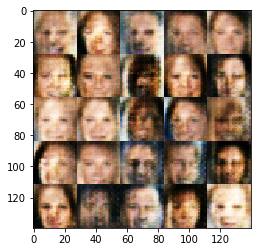

Epoch 2/1... Discriminator Loss: 1.0959... Generator Loss: 0.9072
Epoch 2/1... Discriminator Loss: 1.1399... Generator Loss: 0.8123
Epoch 2/1... Discriminator Loss: 1.3925... Generator Loss: 0.6488
Epoch 2/1... Discriminator Loss: 1.3452... Generator Loss: 0.6225
Epoch 2/1... Discriminator Loss: 1.0054... Generator Loss: 1.5522
Epoch 2/1... Discriminator Loss: 1.3384... Generator Loss: 2.3279
Epoch 2/1... Discriminator Loss: 1.1762... Generator Loss: 1.9218
Epoch 2/1... Discriminator Loss: 1.1514... Generator Loss: 2.0333
Epoch 2/1... Discriminator Loss: 0.9965... Generator Loss: 1.7380
Epoch 2/1... Discriminator Loss: 1.1118... Generator Loss: 1.0537


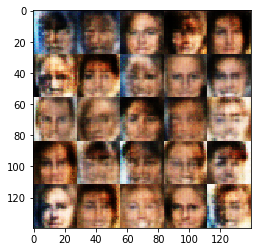

Epoch 2/1... Discriminator Loss: 1.1436... Generator Loss: 1.8873
Epoch 2/1... Discriminator Loss: 1.3629... Generator Loss: 2.5715
Epoch 2/1... Discriminator Loss: 1.2266... Generator Loss: 0.9469
Epoch 2/1... Discriminator Loss: 1.0575... Generator Loss: 1.6267
Epoch 2/1... Discriminator Loss: 0.9766... Generator Loss: 1.0605
Epoch 2/1... Discriminator Loss: 1.0650... Generator Loss: 1.4657
Epoch 2/1... Discriminator Loss: 1.0141... Generator Loss: 1.1093
Epoch 2/1... Discriminator Loss: 1.1332... Generator Loss: 2.1728
Epoch 2/1... Discriminator Loss: 1.1217... Generator Loss: 0.8389


In [16]:
batch_size = 256
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

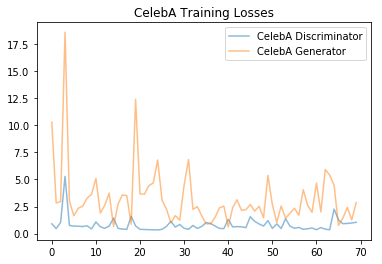

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='CelebA Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='CelebA Generator', alpha=0.5)
plt.title("CelebA Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.